## forecasting ridership

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
dailyRidership.set_index('Date', inplace=True)

In [ ]:
subway = dailyRidership["Subways: Total Estimated Ridership"].rolling(window=7).mean()

In [ ]:
order = (1,1,1)
seasonal_order = (1,1,1,14)

In [ ]:
train_size = int(len(subway)*0.8)
train_data, test_data = subway[:train_size], subway[train_size:]

In [ ]:
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,enforce_stationarity=False, enforce_invertibility=False)
result = model.fit()


c:\Users\tanve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\tanve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast = result.forecast(steps=len(test_data))

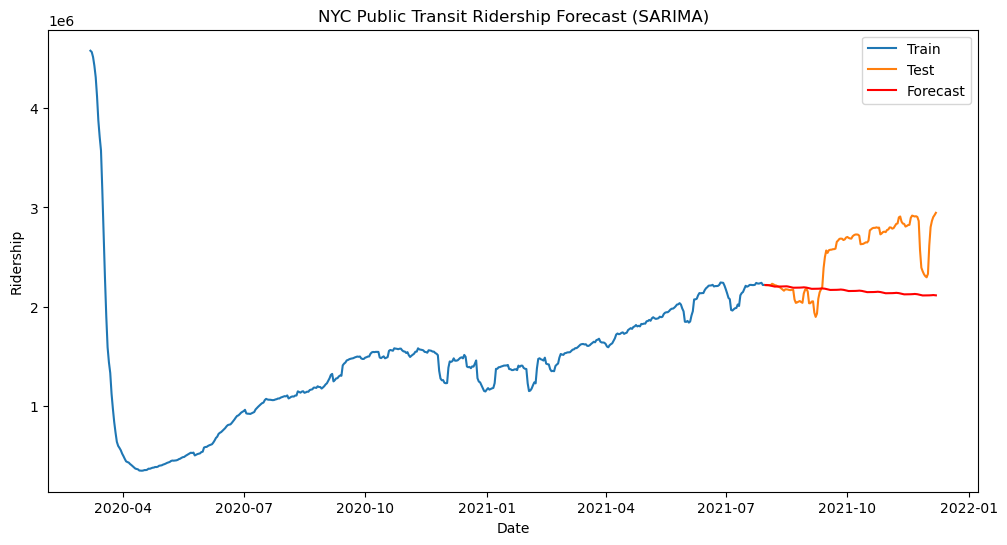

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title('NYC Public Transit Ridership Forecast (SARIMA)')
plt.title('NYC Public Transit Ridership Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
order = (1,1,1)

In [ ]:
model = ARIMA(train_data, order=order)
result = model.fit()

In [ ]:
forecast = result.forecast(steps=len(test_data))

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title('NYC Public Transit Ridership Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()